In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium as fm
from geopy.distance import geodesic
import OLCdistance as olc

In [2]:
def parse_trackpoint(line):
    # Extract components from the line
    time_utc = line[1:7]  # HHMMSS
    latitude_raw = line[7:15]  # DDMMmmmN
    longitude_raw = line[15:24]  # DDDMMmmmE
    gps_altitude = int(line[25:30])  # GGGG
    pressure_altitude = int(line[30:35])  # LLLL

    # Convert UTC time
    hours = int(time_utc[:2])
    minutes = int(time_utc[2:4])
    seconds = int(time_utc[4:6])

    # Convert latitude to decimal degrees
    latitude_deg = int(latitude_raw[:2])
    latitude_min = float(latitude_raw[2:7]) / 1000
    latitude = latitude_deg + latitude_min / 60
    if latitude_raw[7] == 'S':
        latitude *= -1

    # Convert longitude to decimal degrees
    longitude_deg = int(longitude_raw[:3])
    longitude_min = float(longitude_raw[3:8]) / 1000
    longitude = longitude_deg + longitude_min / 60
    if longitude_raw[8] == 'W':
        longitude *= -1

    return {
        "time": f"{hours:02}:{minutes:02}:{seconds:02}",
        "coordinate": (latitude, longitude),
        "gps_altitude_m": gps_altitude,
        "pressure_altitude_m": pressure_altitude,
    }

In [3]:
file_name = "data/2018-07-16 09_13_56.igc"

with open(file_name, 'r') as file:
    lines = file.readlines()

flight_data = [line for line in lines if line.startswith('B')]
df = pd.DataFrame([parse_trackpoint(line) for line in flight_data])
del lines, flight_data
df.head()


,time,coordinate,gps_altitude_m,pressure_altitude_m
0,09:13:56,"(40.031416666666665, 32.32848333333333)",1121,1139
1,09:13:57,"(40.031416666666665, 32.32848333333333)",1121,1139
2,09:13:58,"(40.031416666666665, 32.32848333333333)",1121,1139
3,09:13:59,"(40.03143333333333, 32.32848333333333)",1121,1139
4,09:14:00,"(40.03143333333333, 32.32848333333333)",1121,1139


In [4]:
for i in range(1, len(df)-1):
    if i % 10 > 0:
        df = df.drop([i])

flight_loginterval = int(df["time"].iloc[1][-2:]) - int(df["time"].iloc[0][-2:])

def calculate_distance(row):
    if row["previus_coordinate"] is None:
        return 0
    return geodesic(row["coordinate"], row["previus_coordinate"]).meters


prev_total_distance = 0
def caluculate_total_distance(row):
    global prev_total_distance
    prev_total_distance += row["distance_m"]
    return prev_total_distance

df["previus_coordinate"] = df["coordinate"].shift(1)
df["distance_m"] = df.apply(calculate_distance, axis=1)
df["total_distance_m"] = df.apply(lambda row: caluculate_total_distance(row), axis=1)
df["climb_m"] = df["gps_altitude_m"].diff()
df["climb_rate_m/s"] = df["climb_m"] / flight_loginterval
df["speed_km/s"] = (df["distance_m"]/1000) / (flight_loginterval/3600)
df["distance_from_start_m"] = df.apply(lambda row: geodesic(df["coordinate"].iloc[0], row["coordinate"]).meters, axis=1)
df.head()

,time,coordinate,gps_altitude_m,pressure_altitude_m,previus_coordinate,distance_m,total_distance_m,climb_m,climb_rate_m/s,speed_km/s,distance_from_start_m
0,09:13:56,"(40.031416666666665, 32.32848333333333)",1121,1139,None,0.000000,0.000000,NaN,NaN,-0.000000,0.000000
10,09:14:06,"(40.03143333333333, 32.3285)",1121,1138,"(40.031416666666665, 32.32848333333333)",2.334181,2.334181,0.0,-0.00,-0.168061,2.334181
20,09:14:16,"(40.031616666666665, 32.32815)",1112,1134,"(40.03143333333333, 32.3285)",36.150344,38.484526,-9.0,0.18,-2.602825,36.092138
30,09:14:26,"(40.032383333333335, 32.3278)",1109,1125,"(40.031616666666665, 32.32815)",90.216737,128.701262,-3.0,0.06,-6.495605,122.157456
40,09:14:36,"(40.033366666666666, 32.32865)",1111,1126,"(40.032383333333335, 32.3278)",131.090770,259.792032,2.0,-0.04,-9.438535,216.985565


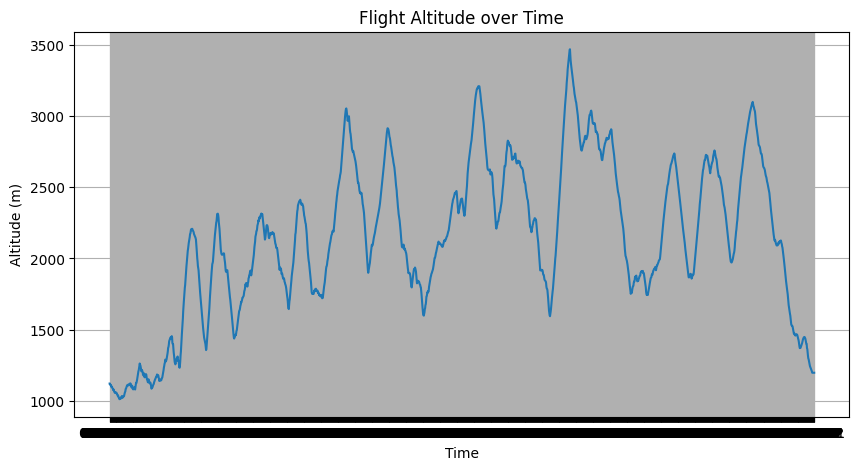

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(df['time'], df['gps_altitude_m'])
plt.xlabel('Time')
plt.ylabel('Altitude (m)')
plt.title('Flight Altitude over Time')
plt.grid(True)
plt.show()

In [6]:
time_difference = str(pd.to_datetime(
    df['time'].iloc[-1]) - pd.to_datetime(df['time'].iloc[0]))
sonuc = (
    f"Toplam mesafe: {df['total_distance_m'].iloc[-1]/1000:.1f} km.\n"
    f"Maksimum yükseklik: {df['gps_altitude_m'].max()} m.\n"
    f"Maksimum tırmanma hızı: {df['climb_rate_m/s'].max()} m/s.\n"
    f"Maksimum iniş hızı: {df['climb_rate_m/s'].min()} m/s.\n"
    f"Maksimum Uzaklık: {df['distance_from_start_m'].max()/1000:.1f} km.\n"
    f"Ortalama hız: {df['speed_km/s'].mean():.1f} km/s.\n"
    f"Maksimum hız: {df['speed_km/s'].max():.1f} km/s.\n"
    f"Toplam süre: {time_difference.split()[2]}\n"
    f"Maksimum İrtifa: {df['pressure_altitude_m'].max()} m.\n"
    f"Minimum İrtifa: {df['pressure_altitude_m'].min()} m.\n"
    f"Kalkış İrtifası: {df['pressure_altitude_m'].iloc[0]} m.\n"
    f"Uçuşu Kayıt Aralığı (log interval): {flight_loginterval} sn.\n"
)

df.to_csv("flight_data.csv", index=False)
print(sonuc)

Toplam mesafe: 258.0 km.
Maksimum yükseklik: 3469 m.
Maksimum tırmanma hızı: 0.92 m/s.
Maksimum iniş hızı: -1.0 m/s.
Maksimum Uzaklık: 177.5 km.
Ortalama hız: -8.6 km/s.
Maksimum hız: -0.0 km/s.
Toplam süre: 05:59:25
Maksimum İrtifa: 3587 m.
Minimum İrtifa: 1025 m.
Kalkış İrtifası: 1139 m.
Uçuşu Kayıt Aralığı (log interval): -50 sn.



In [ ]:
coordinates = df["coordinate"].tolist()
triangle_distance, triangle_points, best_distance, distances = olc.fai_olc_distance(coordinates)
print(f"Maximum FAI OLC Triangle Distance: {triangle_distance:.2f} km.")
print(f"Triangle Points: {triangle_points}")
print(f"Best Distance : {best_distance:.2f} km.")

map = fm.Map(location=coordinates[0], zoom_start=13)
for coord in coordinates:
    fm.CircleMarker(location=coord, radius=1, color='blue',
                    fill=True, fill_color='blue', popup="Point").add_to(map)
for point in triangle_points:
    fm.Marker(location=point, popup="Triangle Point").add_to(map)

map.save("map.html")